In [ ]:
!pip install requests beautifulsoup4 pandas

In [ ]:
import calendar
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import date, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import seaborn as sns

In [ ]:
# Funkcja do Web scrapingu danych pogodowych
def get_weather_data(start_date, end_date):
    weather_data = []
    current_date = start_date
    while current_date <= end_date:
      try:
        day = current_date.day
        year = current_date.year
        month= current_date.month
        url = f"https://en.tutiempo.net/records/epwa/{day}-{str.lower(calendar.month_name[month])}-{year}.html"
        response = requests.get(url)
        print(url)
        soup = BeautifulSoup(response.text, 'html.parser')

        table = soup.find('table', {'style': 'width: 100%'})
        if not table:
            current_date += timedelta(days=1)
            continue

        rows = table.find_all('tr')
        if len(rows) < 2:
            current_date += timedelta(days=1)
            continue

        for row in rows[2:]:
            cells = row.find_all('td')
            if cells:
                hour = cells[0].get_text(strip=True)
                weather_condition = cells[1].get_text(strip=True)
                temperature = cells[2].get_text(strip=True)
                wind = cells[3].get_text(strip=True)
                humidity = cells[4].get_text(strip=True)
                pressure = cells[5].get_text(strip=True)
                weather_data.append({
                    'Month': month,
                    'Day': day,
                    'Year': year,
                    'Hour': hour,
                    'Weather Condition': weather_condition,
                    'Temperature': temperature,
                    'Wind': wind,
                    'Humidity': humidity,
                    'Pressure': pressure
                })
      except:
        print("empty table")
      current_date += timedelta(days=1)
    return weather_data


In [ ]:
#Zbieram dane od 2020-01-01 do 2025-01-01
start_date = date(2020, 1, 1)
end_date = date(2025, 1, 1)

weather_data = get_weather_data(start_date, end_date)

print(weather_data)

Output hidden; open in https://colab.research.google.com to view.

In [130]:
# Usuwanie jednostek z danych
df = pd.DataFrame(weather_data)
df['Temperature'] = df['Temperature'].str.replace('°', '', regex=False).astype(int)
df['Humidity'] = df['Humidity'].str.replace('%', '', regex=False).astype(int)

# Tutaj przy okazji usuwania jednostki kastujemy na int wiec wartosci np. 0900 -> 900
df['Pressure'] = df['Pressure'].str.replace(' hPa', '', regex=False).astype(int)

In [131]:
#Usuwanie wartości bez danych o wietrze
def extract_wind_speed(wind_str):
    match = re.search(r'(\d+)\s*km/h', wind_str)
    if match:
        return int(match.group(1))
    else:
        return None

df['Wind'] = df['Wind'].apply(extract_wind_speed)

df = df.dropna(subset=['Wind'])

In [132]:
#Wyodrebnianie minut
df['Minute'] = df[['Hour']].assign(
        Hour=df['Hour'].str.extract(r'(\d+):(\d+)')[0].astype(int),
    )

#Zrobienie DateTime
df['Datetime'] = pd.to_datetime(
    df[['Year', 'Month', 'Day']].assign(
        Hour=df['Hour'].str.extract(r'(\d+):(\d+)')[0].astype(int),
        Minute=df['Minute'],
        Second=0
    )
)

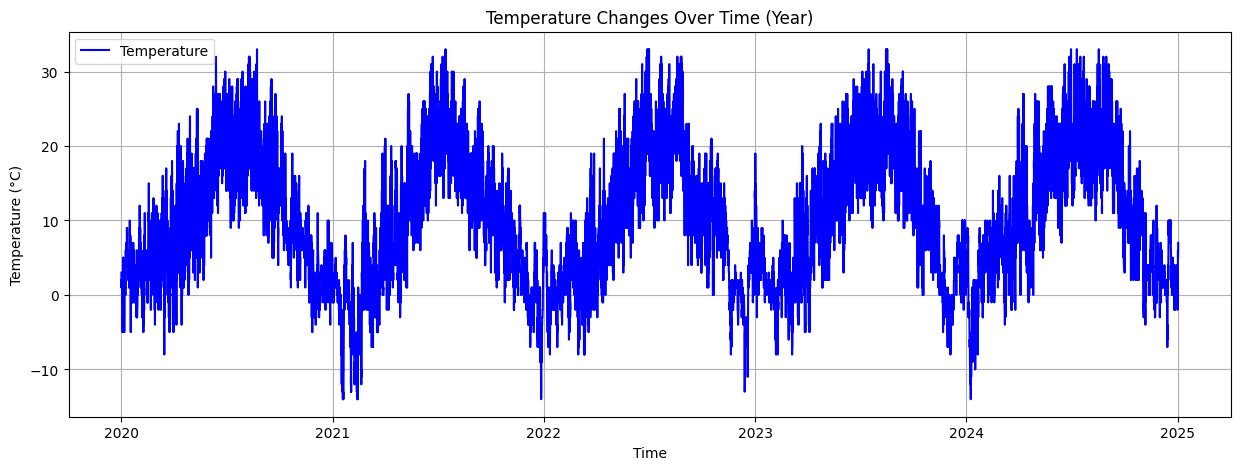

In [133]:
#Usuwam odchyły
lower_bound = df['Temperature'].quantile(0.001)
upper_bound = df['Temperature'].quantile(0.999)
df = df[(df['Temperature'] >= lower_bound) & (df['Temperature'] <= upper_bound)]

#Wykres danych z temperatur
plt.figure(figsize=(15, 5))
plt.plot(df['Datetime'], df['Temperature'], label='Temperature', color='blue')
plt.title('Temperature Changes Over Time (Year)')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()
plt.show()

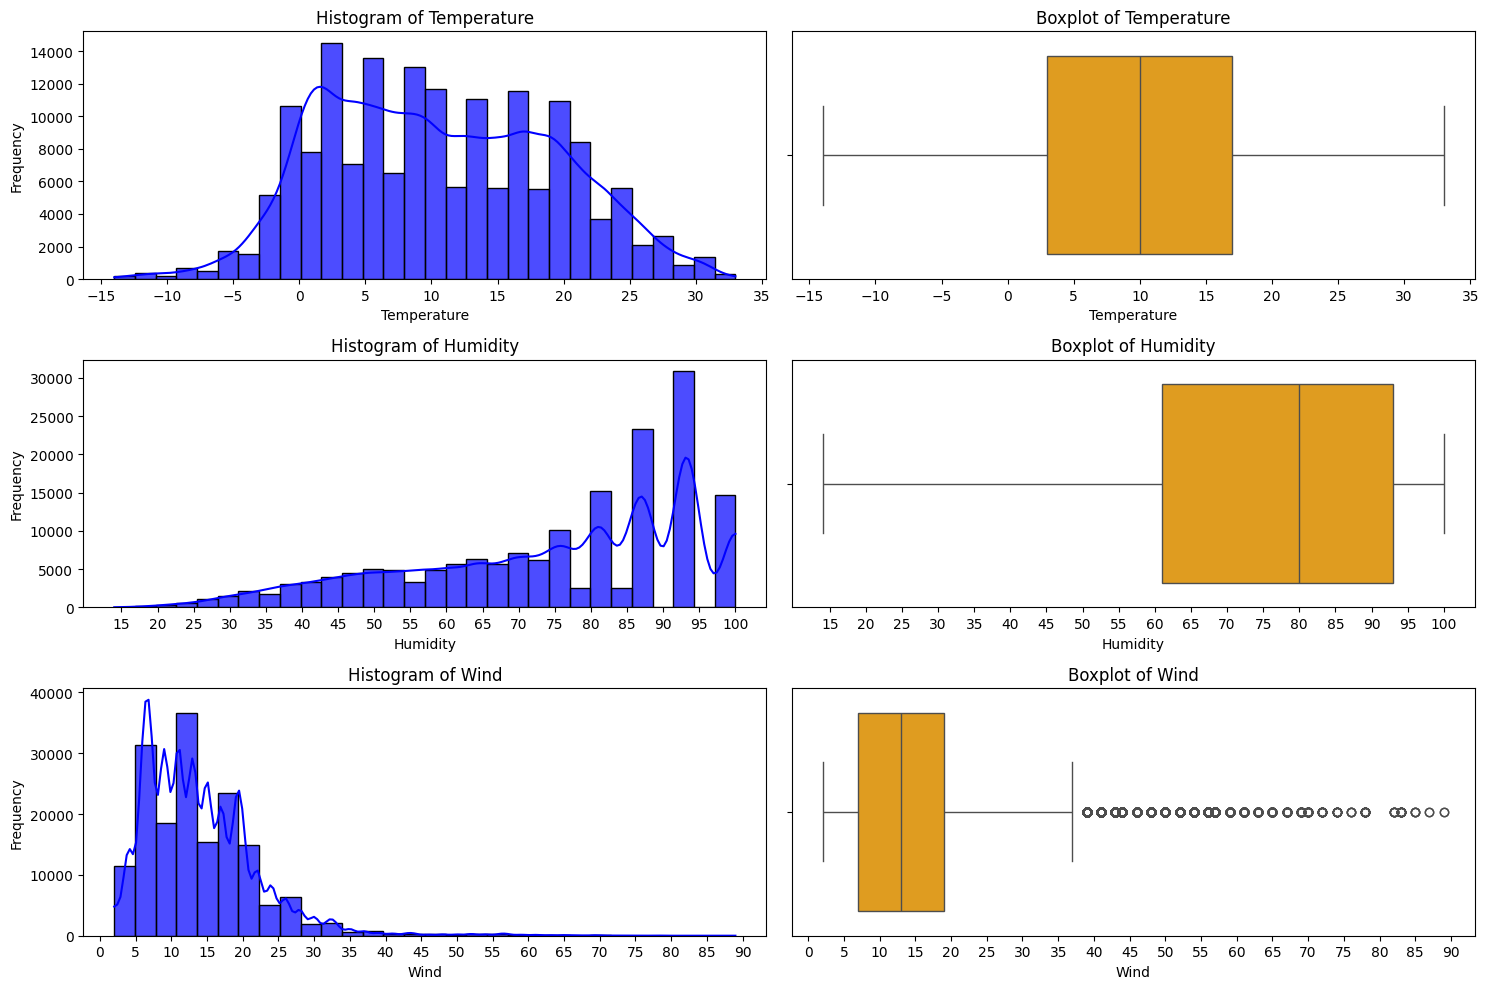

In [163]:
# Histogramy/Boxploty Temperatury Wilgotnosci i Szybkosci witru
import matplotlib.pyplot as plt
continuous_variables = ['Temperature', 'Humidity', 'Wind']
plt.figure(figsize=(15, 10))
for i, variable in enumerate(continuous_variables, 1):
    #Ustalam co ile powinny być 'tiki' na wykresie x
    x_ticks = range(
    int(round(df[variable].min() / 5) * 5),
    int(round(df[variable].max() / 5) * 5) + 5,
    5)
    plt.subplot(len(continuous_variables), 2, 2 * i - 1)
    sns.histplot(df[variable], kde=True, bins=30, color='blue', alpha=0.7)
    plt.title(f'Histogram of {variable}')
    plt.xlabel(variable)
    plt.ylabel('Frequency')
    plt.xticks(x_ticks)

    plt.subplot(len(continuous_variables), 2, 2 * i)
    sns.boxplot(x=df[variable], color='orange')
    plt.title(f'Boxplot of {variable}')
    plt.xlabel(variable)
    plt.xticks(x_ticks)
plt.tight_layout()
plt.show()
#Mediana temperatur wynosi 10, brak wiekszych odchyłow od normy prze z wczesniejsze wyczyszczenie
#Mediana Wilgotnosci to 80, brak odcyhłow ze wzgledu na procentowy rozkład
#Mediana predkosci wiatru wynoski okolo 13. W przypadku wiatru było sporo dni gdzie wiatr miał spore odchyły od normy - co sprawia ze jest mniej przewidywalny

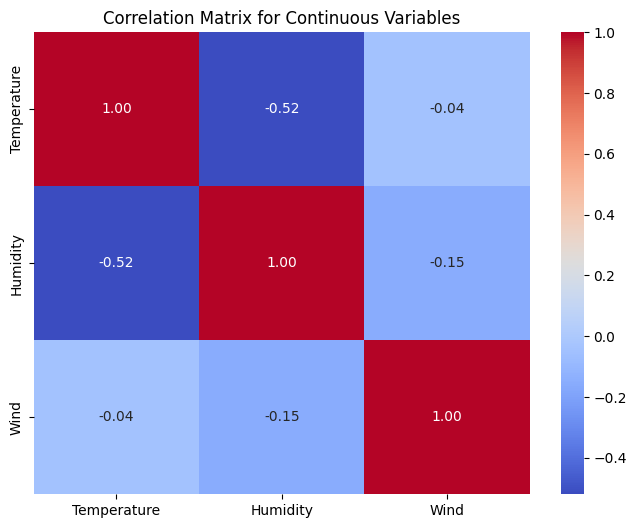

In [135]:
# Macierz korelacji miedzy Temperatura, Wilgotnościa i Szybkoscia waitru
continuous_columns = ['Temperature', 'Humidity', 'Wind']
correlation_matrix = df[continuous_columns].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Correlation Matrix for Continuous Variables')
plt.show()
# Z macierzy wynika że ze wzrostem temperatury spada wilgotnosc - wiec istnieje miedzy nimi spora korelacja

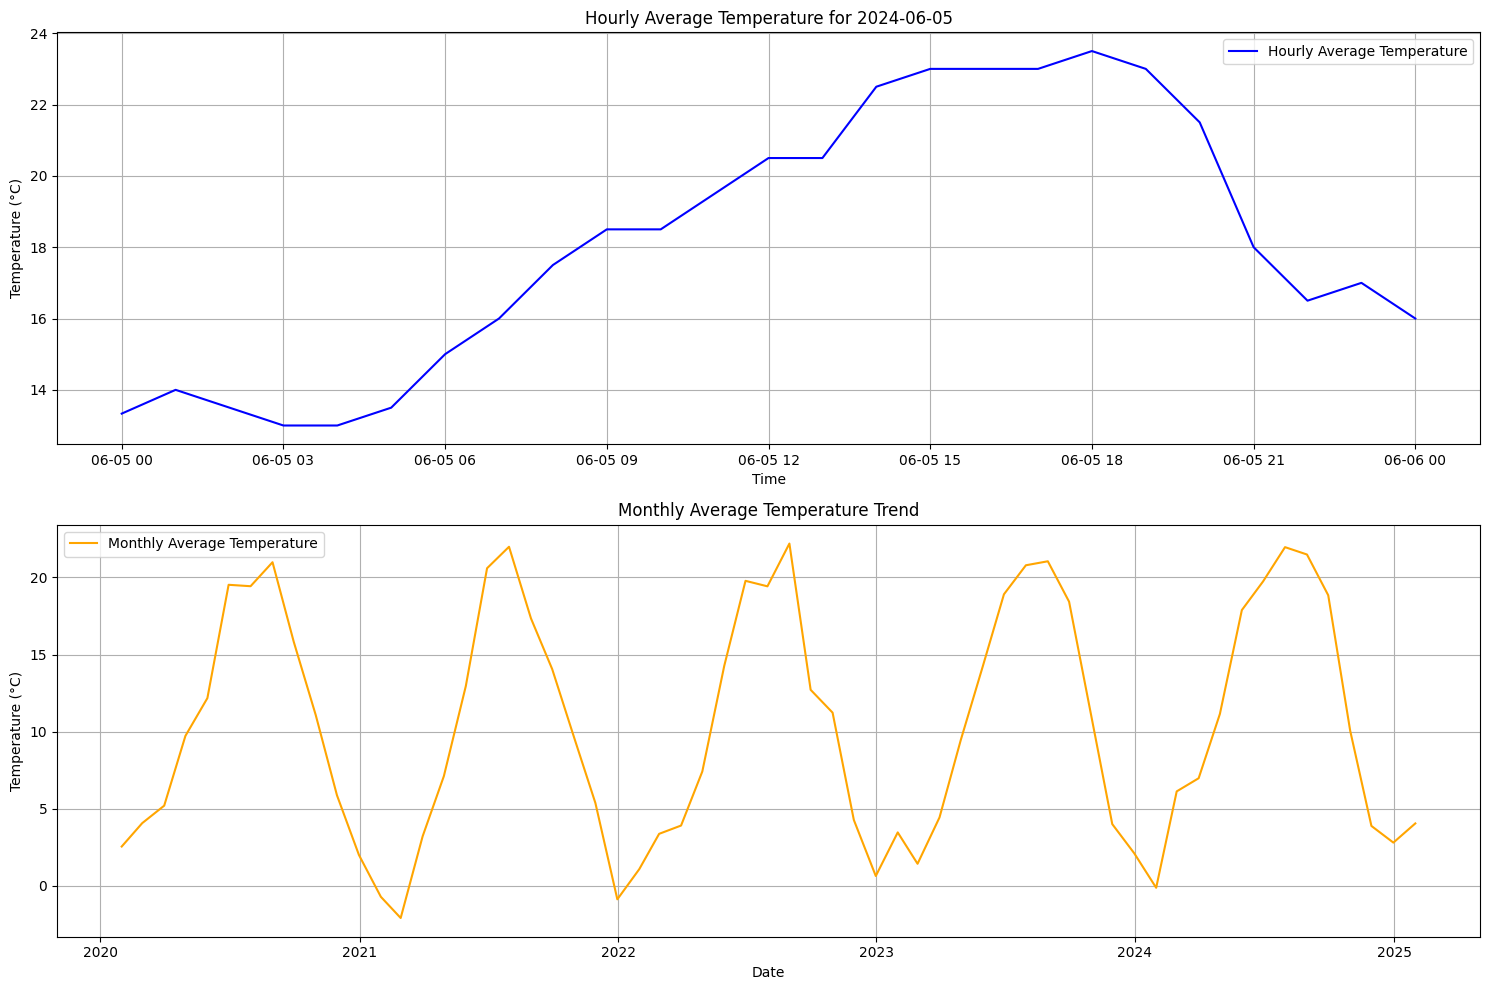

In [156]:
#Wykresy trendu temperatur
monthly_avg = df.resample('ME', on='Datetime')['Temperature'].mean()

single_day = df[(df['Datetime'] >= '2024-06-05') & (df['Datetime'] <= '2024-06-06')]
single_day = single_day.resample('h', on='Datetime')['Temperature'].mean()

plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(single_day.index, single_day, label='Hourly Average Temperature', color='blue')
plt.title('Hourly Average Temperature for 2024-06-05')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()


plt.subplot(2, 1, 2)
plt.plot(monthly_avg.index, monthly_avg, label='Monthly Average Temperature', color='orange')
plt.title('Monthly Average Temperature Trend')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()
#Wykres dzienny pokazuje jak zmienia sie temperatura na przestrzeni godzin w ciagu 1 dnia (dla wybranego dnia w 2024-06-05)
#Wykres miesieczny przedstaia jak zmienaia sie temperatura zaleznie od pory roku (Dnia/miesiaca)

In [157]:
#Rozdzielenie wartości data frame-u
df['Hour'] = df['Datetime'].dt.hour
df['Month'] = df['Datetime'].dt.month
df['Day'] = df['Datetime'].dt.day

#Model bedzie brał dzien z dokladna godzina, wilgotnoscia i robil predykcje temperatury i predkosci wiatru - jest to mozliwe ze wzgledu na to ze pogoda jest zalezna bezposrednio od pory roku co ukazuja trnedy i wilgotnosci
#Temperatura jest bezposrednio powiazana  z wilgotnoscia wiec dodam ja jako zmienna wejsciowa
#Najgorzej przewidywane powinna byc predkosc waitru - nie jest ona zalezna od temperatury
y = df[['Temperature', 'Wind']]
X = df[['Hour', 'Minute', 'Month', 'Day', 'Humidity']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

In [158]:
#Zdecydowałem sie na model regresyjny Random Forest - otrzymywalem z niego najlepsze wyniki
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=1337))
model.fit(X_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(random_state=1337))

In [161]:
# Wartości błędów predykcji Teperatury i prędkości wiatru
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test['Temperature'], y_pred[:, 0])
r2 = r2_score(y_test['Temperature'], y_pred[:, 0])

print(f"Średni kwadratowy błąd temperatury: {mse}")
print(f"Temperatury R-kwadrat: {r2}\n")

mse = mean_squared_error(y_test['Wind'], y_pred[:, 1])
r2 = r2_score(y_test['Wind'], y_pred[:, 1])

print(f"Średni kwadratowy błąd prędkości wiatru: {mse}")
print(f"Wiatr R-kwadrat: {r2}")
#Zgodnie z przewidywaniem temperatura jest przewidywana na bardzo dokladnym poziomie, predkosc wiatru wypada gorzej

Średni kwadratowy błąd temperatury: 2.49684204155195
Temperatury R-kwadrat: 0.9668633565985926

Średni kwadratowy błąd prędkości wiatru: 20.27134255364144
Wiatr R-kwadrat: 0.6937520879270366


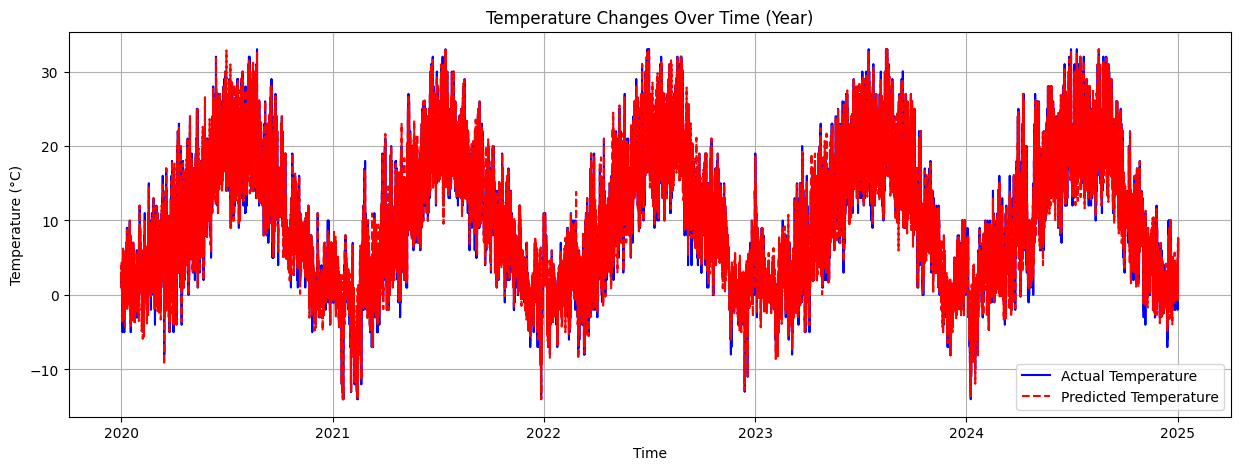

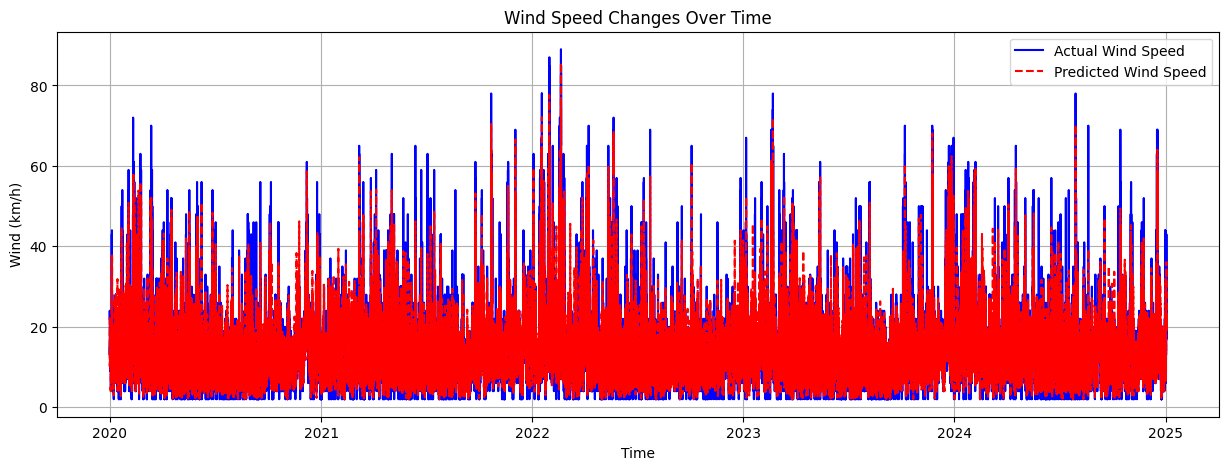

In [162]:
# Porównanie predykcji do całego datasetu
y_pred_all = model.predict(X)

plt.figure(figsize=(15, 5))
plt.plot(df['Datetime'], df['Temperature'], label='Actual Temperature', color='blue')
plt.plot(df['Datetime'], y_pred_all[:, 0], label='Predicted Temperature', color='red', linestyle='dashed')
plt.title('Temperature Changes Over Time (Year)')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(df['Datetime'], df['Wind'], label='Actual Wind Speed', color='blue')
plt.plot(df['Datetime'], y_pred_all[:, 1], label='Predicted Wind Speed', color='red', linestyle='dashed')
plt.title('Wind Speed Changes Over Time')
plt.xlabel('Time')
plt.ylabel('Wind (km/h)')
plt.legend()
plt.grid()
plt.show()

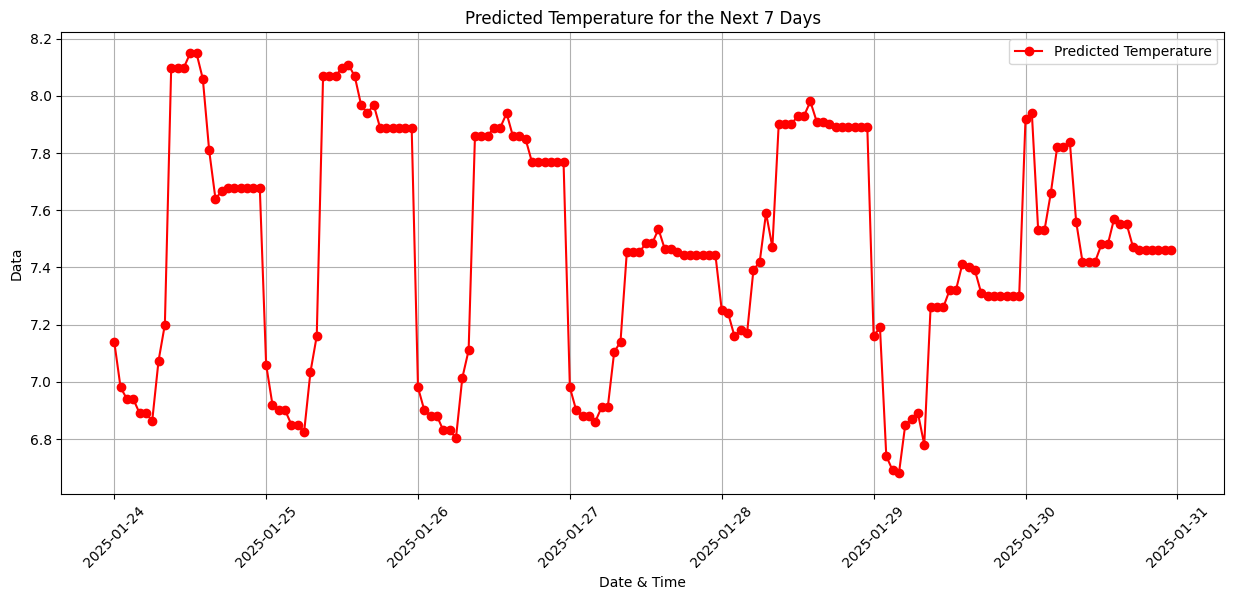

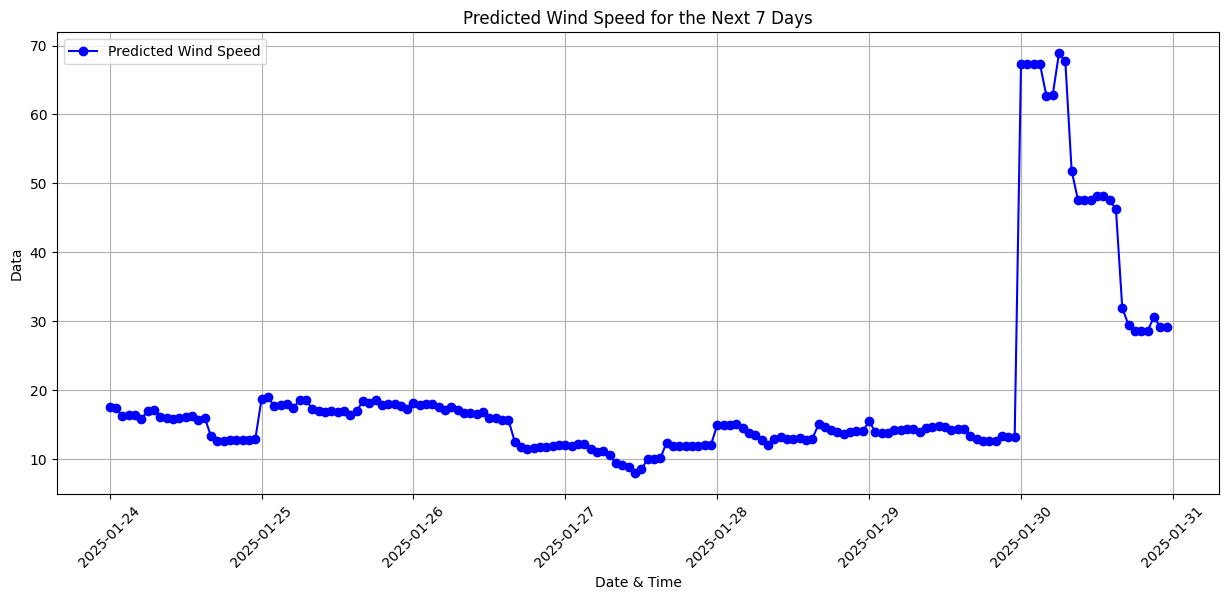

In [111]:
# Predykcja pogody na nastepne 7 dni
dates = pd.date_range(start="2025-01-24", periods=7, freq="D")
hours = np.arange(24)
upcoming_days_df = pd.DataFrame([
    {'Datetime': pd.Timestamp(date) + pd.Timedelta(hours=hour), 'Day': date.day, 'Month': date.month, 'Year': date.year, 'Hour': hour, 'Minute': 0, 'Humidity': 66}
    for date in dates for hour in hours
])
X_upcoming = upcoming_days_df[['Hour', 'Minute', 'Month', 'Day', 'Humidity']]
y_pred_upcoming = model.predict(X_upcoming)
y_pred_temperature = y_pred_upcoming[:, 0]
upcoming_days_df['Predicted Temperature'] = y_pred_temperature


plt.figure(figsize=(15, 6))
plt.plot(upcoming_days_df['Datetime'], y_pred_upcoming[:, 0], label='Predicted Temperature', color='red', marker='o')
plt.title('Predicted Temperature for the Next 7 Days')
plt.xlabel('Date & Time')
plt.ylabel('Data')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(upcoming_days_df['Datetime'], y_pred_upcoming[:, 1], label='Predicted Wind Speed', color='blue', marker='o')
plt.title('Predicted Wind Speed for the Next 7 Days')
plt.xlabel('Date & Time')
plt.ylabel('Data')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()